In [2]:
import numpy as np
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [1]:
# draw the tensor computational graph using graphviz
from torchviz import make_dot

def draw_dot(tensor):
    dot = make_dot(tensor)
    dot.format = 'png'
    dot.render('tmp')
    dot.view()

In [3]:
# testing graph
x = torch.tensor(1.0, dtype=torch.float32, requires_grad=True)
y = torch.tensor(2.0, dtype=torch.float32, requires_grad=True)
z = x + y
draw_dot(z)

In [4]:
class F:
    @staticmethod
    def B(x, k, i, t):
       if k == 0:
          return 1.0 if t[i] <= x < t[i+1] else 0.0
       
       if t[i+k] == t[i]:
          c1 = 0.0
       else:
          c1 = (x - t[i])/(t[i+k] - t[i]) * F.B(x, k-1, i, t)
           
       if t[i+k+1] == t[i+1]:
          c2 = 0.0
       else:
          c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * F.B(x, k-1, i+1, t)
       return c1 + c2    
    
    @staticmethod
    def bspline(x, c, range_c, k):
        range_c = (range_c[0], range_c[1] + 1e-6)
        t = np.concatenate(([range_c[0]] * k, np.linspace(range_c[0], range_c[1], len(c)-k+1), [range_c[1]] * k))
        return sum(c[i] * F.B(x, k, i, t) for i in range(len(c)))
    
    
    @staticmethod
    def silu(x):
        return x / (1 + torch.exp(-x))
    
    @staticmethod
    def mse(y_pred, y):
        sum = 0
        for i in range(len(y_pred)):
            sum += (y_pred[i] - y[i])**2
        return sum / len(y_pred)

In [5]:
x = torch.tensor(3.0, dtype=torch.float32, requires_grad=True)
c = torch.tensor([1, 2, 3, 4, 3, 2, 1], dtype=torch.float32, requires_grad=True)
k = 3

y = F.bspline(x, c, (-3, 3), k)
print(y)
draw_dot(y)

tensor(1.0000, grad_fn=<AddBackward0>)


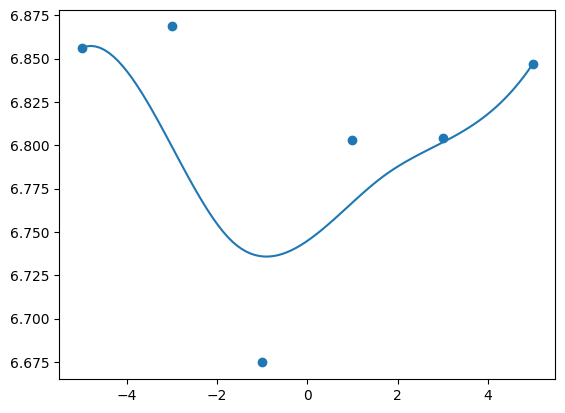

In [6]:
c = [6.8562, 6.8685, 6.6747, 6.8028, 6.8039, 6.8469]
k = 3

# plot the bspline
x = np.linspace(-5, 5, 100)
y = [F.bspline(i, c, (-5, 5), k) for i in x]
# scatter c
plt.scatter([i for i in np.linspace(-5, 5, len(c))], c) 
plt.plot(x, y)
plt.show()

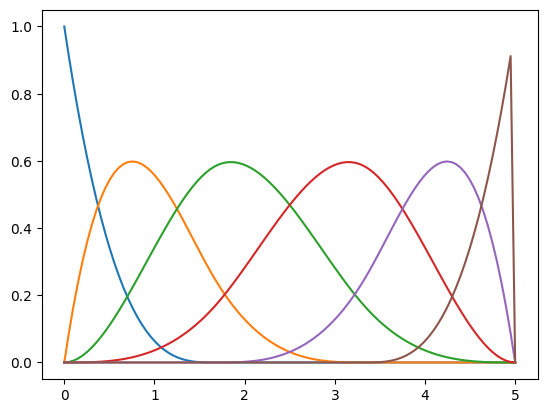

In [7]:
t = np.concatenate(([0] * k, np.linspace(0, len(c)-1, len(c)-k+1), [len(c)-1] * k))
x = np.linspace(0, len(c)-1 , 100)

for i in range(len(c)):
    y = [F.B(j, k, i, t) for j in x]
    plt.plot(x, y)

In [8]:
class Phi:
    def __init__(self, num_c, range_c, k):
        self.num_c = num_c
        self.range_c = range_c
        self.k = k
        self.c = torch.normal(0, 0.1, (num_c, ), requires_grad=True)
        self.wb = torch.randn(1, requires_grad=True)
        self.ws = torch.randn(1, requires_grad=True)
        
    def parameters(self):
        return [self.c, self.wb, self.ws]
    
    def __call__(self, x):
        return self.wb * F.bspline(x, self.c, self.range_c, self.k) + self.ws * F.silu(x)
        
    # def __call__(self, x):
    #     return F.bspline(x, self.c, self.range_c, self.k)
    
    def plot(self):
        x = np.linspace(self.range_c[0], self.range_c[1], 100)
        y = [F.bspline(i, self.c, self.range_c, self.k).detach().numpy() for i in x]
        plt.plot(x, y)
        plt.scatter([i for i in np.linspace(self.range_c[0], self.range_c[1], self.num_c)], self.c.detach().numpy())
        plt.show()

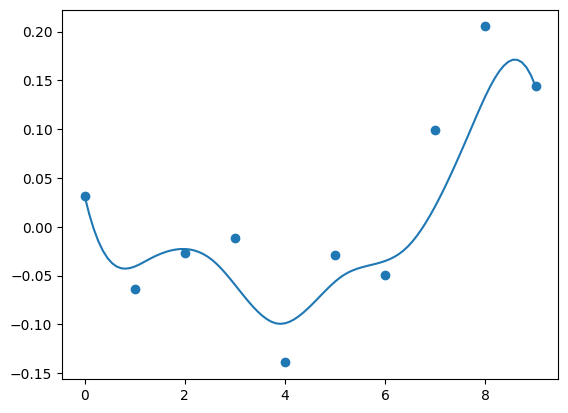

In [9]:
phi = Phi(10, (0, 9), 3)
phi.plot()

x = torch.tensor(5.0, dtype=torch.float32, requires_grad=True)
y = phi(x)

In [10]:
class Layer:
    def __init__(self, input_size, output_size, num_control_points, range_c, k):
        self.input_size = input_size
        self.output_size = output_size
        # function[0][3] is the function from input 3 to output 0
        self.functions = [[Phi(num_control_points, range_c, k) for i in range(input_size)] for j in range(output_size)]
        
    def parameters(self):
        return [param for i in range(self.output_size) for j in range(self.input_size) for param in self.functions[i][j].parameters()]
    
    # def forward(self, x):
    #     t = torch.stack([torch.stack([self.functions[i][j](x[j]) for j in range(self.input_size)]) for i in range(self.output_size)])
    #     return torch.stack([torch.sum(t[i]) for i in range(self.output_size)])
    
    def forward(self, x):
        output = []
        for i in range(self.output_size):
            sum = 0
            for j in range(self.input_size):
                sum += self.functions[i][j](x[j])
            output.append(sum)
        return torch.stack(output)
        
                
    
    def __call__(self, x):
        return self.forward(x)

In [11]:
layer = Layer(1, 1, 6, (-5, 5), 3)

x = torch.tensor([5.0], dtype=torch.float32, requires_grad=True)
y = layer(x)
draw_dot(y)


In [50]:
class KAN(nn.Module):
    def __init__(self, input_size, layers, num_control_points, range_c, k):
        super(KAN, self).__init__()
        self.input_size = input_size
        layers = [input_size] + layers
        self.layers = [Layer(layers[i-1], layers[i], num_control_points, range_c, k) for i in range(1, len(layers))]
        
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]
    
    
    def forward(self, x):
        def single_forward(x):
            for layer in self.layers:
                x = layer(x)
            return x
        
        def batch_forward(x):
            return torch.stack([single_forward(i) for i in x]).squeeze(1)
        
        if len(x.shape) == 1:
            # x = x.clone().detach().requires_grad_(True)
            return single_forward(x)
        else:
            # x = x.clone().detach().requires_grad_(True)
            return batch_forward(x)
    
    
    def __call__(self, x):
        return self.forward(x)

In [51]:
def f(x, y):
    return f3(x, y)

def f1(x):
    return np.exp(x)

def f2(x):
    return np.exp(np.sin(x))

def f3(x, y):
    return x**2 + y**2

In [58]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-10, 10, 100)

X = [[x[i], y[i]] for i in range(len(x))]
X = np.array(X)
X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=True)
Y = torch.tensor(np.array([f(x, y) for x, y in X]), dtype=torch.float32).unsqueeze(1)

In [59]:
kan = KAN(2, [1], 6, (-10, 10), 3)

x = torch.tensor([[5.0, 5,0]], dtype=torch.float32, requires_grad=True)
y = kan(x)
draw_dot(y)

In [60]:
# train the model
optimizer = torch.optim.Adam(kan.parameters(), lr=1)

for i in range(200):
    optimizer.zero_grad()
    y_pred = kan(X_tensor)
    loss = F.mse(y_pred, Y)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

0 3285.336181640625
1 2783.310302734375
2 2215.89501953125
3 1652.010009765625
4 1228.607177734375
5 1088.6788330078125
6 1140.8624267578125
7 1093.3851318359375
8 875.8928833007812
9 598.8980712890625
10 361.9769592285156
11 199.89865112304688
12 104.93417358398438
13 64.18901062011719
14 72.11385345458984
15 120.30410766601562
16 183.85556030273438
17 224.11851501464844
18 215.72552490234375
19 167.07009887695312
20 108.91039276123047
21 69.99466705322266
22 60.796077728271484
23 71.35787963867188
24 82.18746948242188
25 79.92343139648438
26 65.32335662841797
27 49.28715896606445
28 41.932674407958984
29 42.954490661621094
30 42.6645393371582
31 34.27519226074219
32 22.164039611816406
33 16.222030639648438
34 20.710708618164062
35 30.04140853881836
36 35.003971099853516
37 31.7125186920166
38 23.792236328125
39 17.323501586914062
40 14.739409446716309
41 13.559535026550293
42 10.705810546875
43 6.7351250648498535
44 4.822342395782471
45 6.545299530029297
46 9.936362266540527
47 11.67

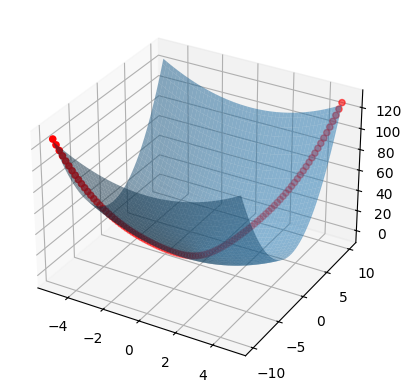

In [61]:
# plot the result in 3d space interactive plot

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(-5, 5, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = np.array([[f(x, y) for x, y in zip(x, y)] for x, y in zip(X, Y)])

ax.plot_surface(X, Y, Z, alpha=0.5)

X = [[x[i], y[i]] for i in range(len(x))]
X = np.array(X)
X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=True)
Y = torch.tensor(np.array([f(x, y) for x, y in X]), dtype=torch.float32).unsqueeze(1)

Y_pred = kan(X_tensor).detach().numpy()
ax.scatter(X[:, 0], X[:, 1], Y_pred, c='r')
plt.show()

In [ ]:
# plot the result in 3d interactive



In [ ]:
phi = kan.layers[0].functions[0][0]
phi.plot()

In [ ]:
y = kan(X[0])
draw_dot(y)